# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.287951,True,5.419658
1,1.031342,True,8.775682
2,0.316439,False,0.879494
3,1.806240,False,2.658104
4,1.526564,True,6.776375
...,...,...,...
995,1.168410,False,1.986874
996,0.505628,False,1.447253
997,-1.327059,True,4.170412
998,1.689609,False,3.016132


<Axes: xlabel='v0'>

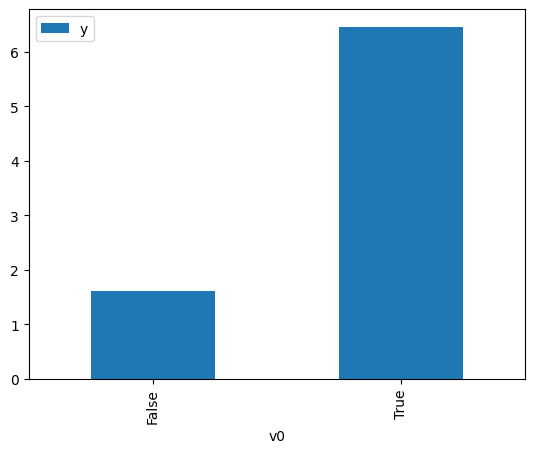

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

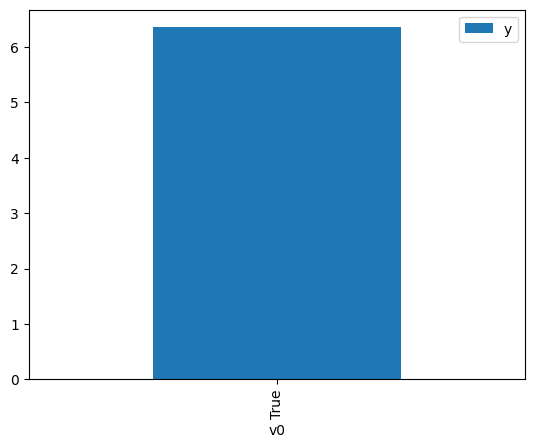

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.096423,False,2.728192,0.430456,2.323118
1,0.234743,False,0.504656,0.469090,2.131788
2,1.709650,False,4.678006,0.403441,2.478676
3,-0.747075,False,-0.129939,0.513539,1.947271
4,0.794631,False,1.164954,0.443915,2.252682
...,...,...,...,...,...
995,4.357516,False,8.439867,0.295023,3.389567
996,2.099857,False,5.908547,0.386540,2.587052
997,0.139886,False,0.670378,0.473374,2.112494
998,1.449292,False,2.271593,0.414849,2.410513


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.262333,True,5.367825,0.508423,1.966865
1,1.360745,True,7.700396,0.581249,1.720433
2,1.211453,True,7.106994,0.574648,1.740195
3,1.372096,True,7.986810,0.581750,1.718952
4,1.680814,True,7.672190,0.595300,1.679825
...,...,...,...,...,...
995,-0.020601,True,3.900526,0.519369,1.925414
996,0.807608,True,6.465844,0.556665,1.796412
997,0.667025,True,7.001247,0.550368,1.816967
998,1.327234,True,7.607409,0.579770,1.724822


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.968
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                          1.520e+04
Date:                Tue, 30 Jan 2024   Prob (F-statistic):                        0.00
Time:                        17:16:46   Log-Likelihood:                         -1389.5
No. Observations:                1000   AIC:                                      2783.
Df Residuals:                     998   BIC:                                      2793.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8170      0.028     65.919      0.000       1.763       1.871
x2             4.9995      0.048    103.773      0.000       4.905       5.094
==============================================================================
Omnibus:                        0.395   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.483
Skew:                          -0.024   Prob(JB):                        0.785
Kurtosis:                       2.904   Cond. No.                         2.27
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""